In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import json 

In [2]:
%ls

flcore/          run_HAR_WB.sh         run_multi_model.sh  run_SLEEP_WB.sh
get_mean_std.py  run_hybrid_pamap2.sh  run_PAMAP2.sh       testcode.ipynb
main.py          run_hybrid.sh         run_PAMAP2_WB.sh    utils/
models/          run_kd.sh             run.sh              wandb/
run_HAR.sh       run_kdx.sh            run_SLEEP.sh


In [3]:
json_file = "../dataset/SLEEP/config.json"
# dataset/SLEEP/config.json
with open(json_file, "r") as f:
    config = json.load(f)


In [4]:
n_client = config['num_clients']
n_classes = config['num_classes']
data_info = config['Size of samples for labels in clients']


In [5]:
n_client, n_classes, data_info

(15,
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [{'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
   'n_samples': [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]},
  {'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
   'n_samples': [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]},
  {'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
   'n_samples': [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]},
  {'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
   'n_samples': [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]},
  {'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
   'n_samples': [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]},
  {'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
   'n_samples': [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]},
  {'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
   'n_samples': [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]},
  {'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
   'n_samples': [41, 35, 40, 41, 38, 42, 43, 41, 38, 

In [6]:
for data in data_info:
    print("Class : ", data['classes'])
    print("Size : ", data['n_samples'])

Class :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Size :  [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]
Class :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Size :  [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]
Class :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Size :  [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]
Class :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Size :  [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]
Class :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Size :  [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]
Class :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Size :  [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]
Class :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Size :  [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]
Class :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Size :  [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]
Class :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Size :  [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]
Class :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Size : 

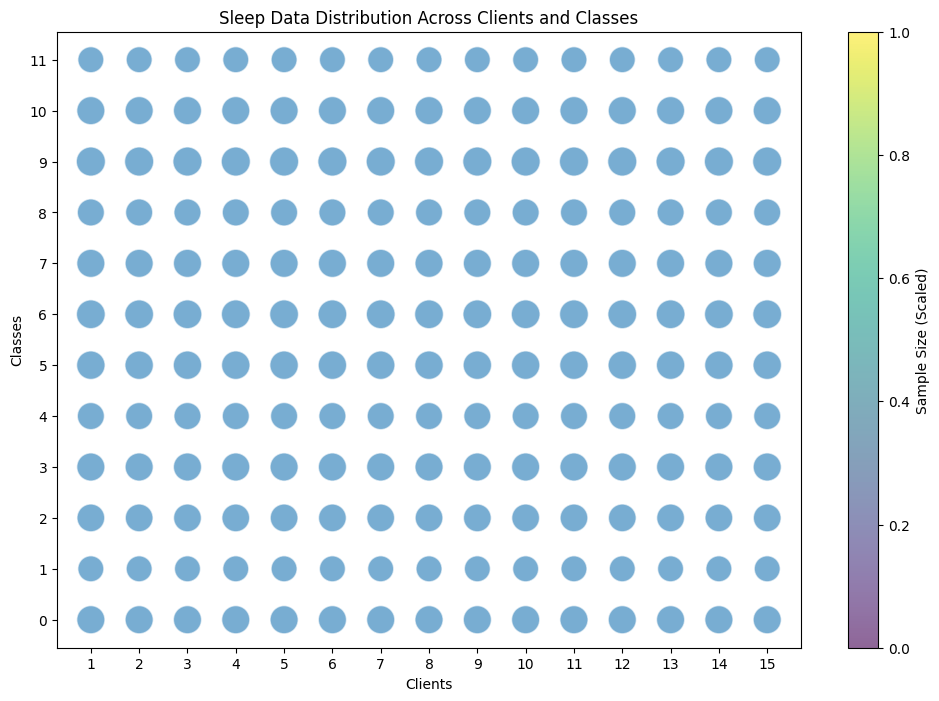

In [7]:
# Reimport required libraries after kernel reset
import matplotlib.pyplot as plt
import numpy as np

# Redefine data
num_clients = 15  # Number of clients
classes = list(range(12))  # Classes: 0 to 11
sizes = [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]  # Sizes for each class

# Prepare data for scatter plot
x = np.repeat(range(1, num_clients + 1), len(classes))  # Repeat client indices for each class
y = np.tile(classes, num_clients)  # Repeat class indices across all clients
sizes = np.tile(sizes, num_clients)  # Repeat class sizes across all clients

# Scale sizes for better visualization in scatter plot
scaled_sizes = [s * 10 for s in sizes]  # Adjust size multiplier for clarity

# Create scatter plot with dot circles
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(x, y, s=scaled_sizes, alpha=0.6, edgecolors="w")

ax.set_title('Sleep Data Distribution Across Clients and Classes')
ax.set_xlabel('Clients')
ax.set_ylabel('Classes')
ax.set_xticks(range(1, num_clients + 1))
ax.set_yticks(classes)

# Add a color bar for clarity (optional)
plt.colorbar(scatter, label='Sample Size (Scaled)')

plt.show()


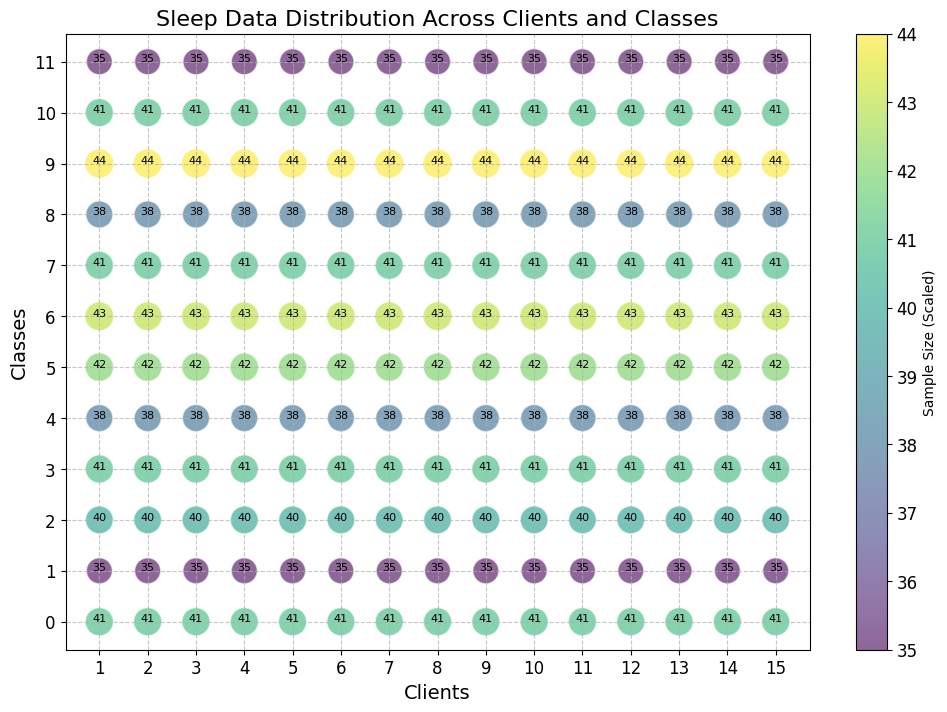

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(x, y, s=scaled_sizes, alpha=0.6, edgecolors="w", c=sizes, cmap='viridis')

# Set title and labels with improved font size
ax.set_title('Sleep Data Distribution Across Clients and Classes', fontsize=16)
ax.set_xlabel('Clients', fontsize=14)
ax.set_ylabel('Classes', fontsize=14)

# Set ticks with improved font size
ax.set_xticks(range(1, num_clients + 1))
ax.set_yticks(classes)
ax.tick_params(axis='both', which='major', labelsize=12)

# Add grid lines for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Add a color bar for clarity
cbar = plt.colorbar(scatter, ax=ax, label='Sample Size (Scaled)')
cbar.ax.tick_params(labelsize=12)

# Add annotations for each point
for i in range(len(x)):
    ax.annotate(f'{sizes[i]}', (x[i], y[i]), textcoords="offset points", xytext=(0, 0), ha='center', fontsize=8, color='black')

plt.show()

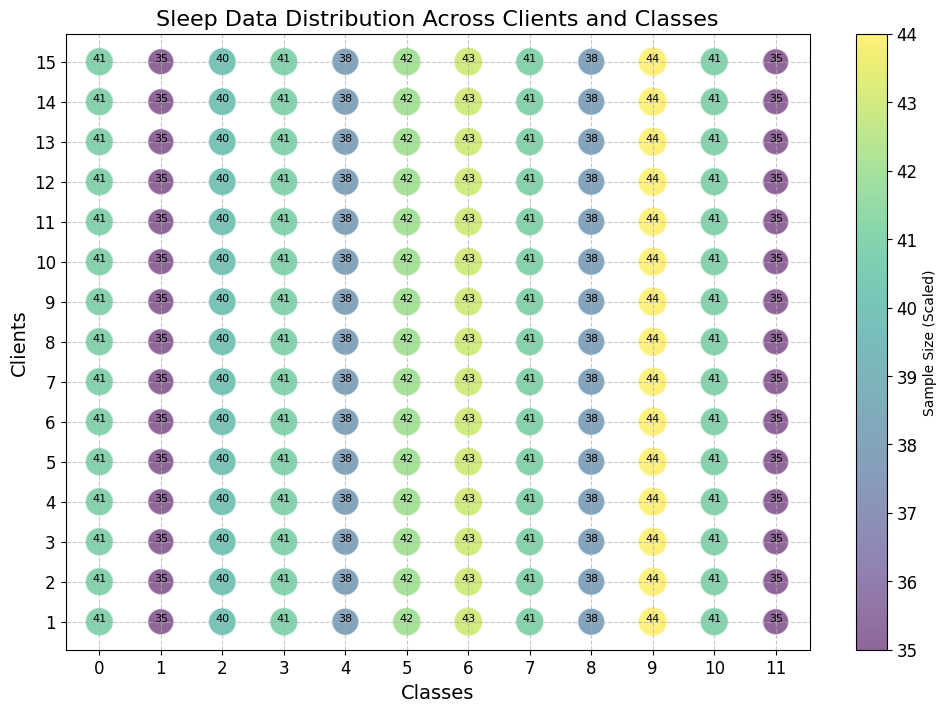

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(y, x, s=scaled_sizes, alpha=0.6, edgecolors="w", c=sizes, cmap='viridis')

# Set title and labels with improved font size
ax.set_title('Sleep Data Distribution Across Clients and Classes', fontsize=16)
ax.set_xlabel('Classes', fontsize=14)
ax.set_ylabel('Clients', fontsize=14)

# Set ticks with improved font size
ax.set_xticks(classes)
ax.set_yticks(range(1, num_clients + 1))
ax.tick_params(axis='both', which='major', labelsize=12)

# Add grid lines for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Add a color bar for clarity
cbar = plt.colorbar(scatter, ax=ax, label='Sample Size (Scaled)')
cbar.ax.tick_params(labelsize=12)

# Add annotations for each point
for i in range(len(x)):
    ax.annotate(f'{sizes[i]}', (y[i], x[i]), textcoords="offset points", xytext=(0, 0), ha='center', fontsize=8, color='black')

plt.show()

In [10]:
data_size = [data['n_samples'] for data in data_info]
for data in data_info:
    print("Class : ", data['classes'])
    print("Size : ", data['n_samples'])

Class :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Size :  [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]
Class :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Size :  [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]
Class :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Size :  [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]
Class :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Size :  [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]
Class :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Size :  [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]
Class :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Size :  [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]
Class :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Size :  [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]
Class :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Size :  [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]
Class :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Size :  [41, 35, 40, 41, 38, 42, 43, 41, 38, 44, 41, 35]
Class :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Size : 

In [11]:
sleep_raw_file = "../dataset/SLEEP/all/test__static_BuiVanCanh.npy"
sleep_raw = np.load(sleep_raw_file)
data_sleep = sleep_raw[:, 1:-1].reshape(12, 3, 3000)
label_sleep = sleep_raw[:, -1].reshape(12, 3000)

In [12]:
data_sleep.shape

(12, 3, 3000)

In [13]:
sample = data_sleep[0]
sample.shape

(3, 3000)

In [14]:
label_id = label_sleep[0]

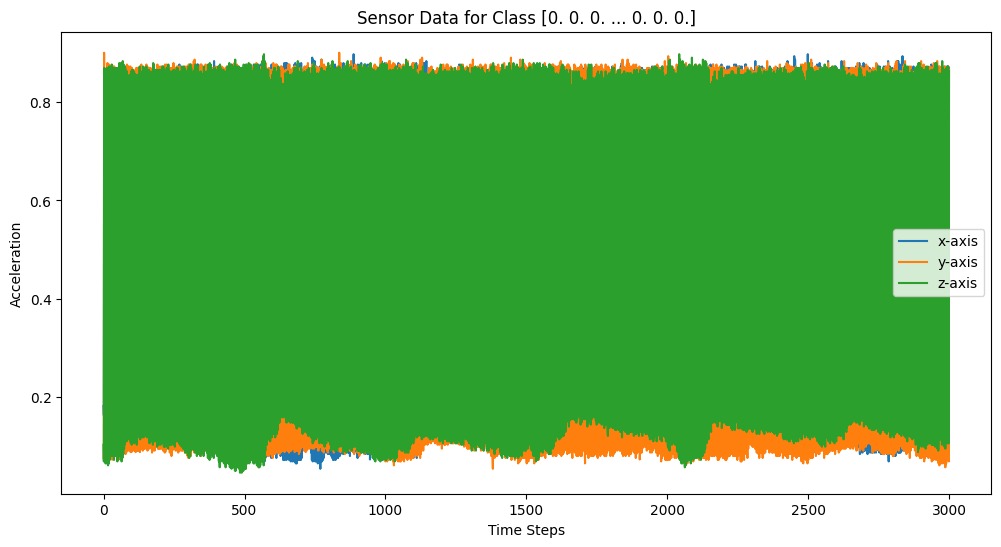

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(sample[0], label='x-axis')
plt.plot(sample[1], label='y-axis')
plt.plot(sample[2], label='z-axis')
plt.title(f'Sensor Data for Class {label_id}')
plt.xlabel('Time Steps')
plt.ylabel('Acceleration')
plt.legend()
plt.show()


In [16]:
total_data_sleep  = np.array(data_size).sum(axis=1)
total_data_sleep

array([479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479,
       479, 479])

In [17]:
data_sleep_train = [479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479]
data_sleep_test = [120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120]
total_data_sleep = np.array(data_sleep_train) + np.array(data_sleep_test)

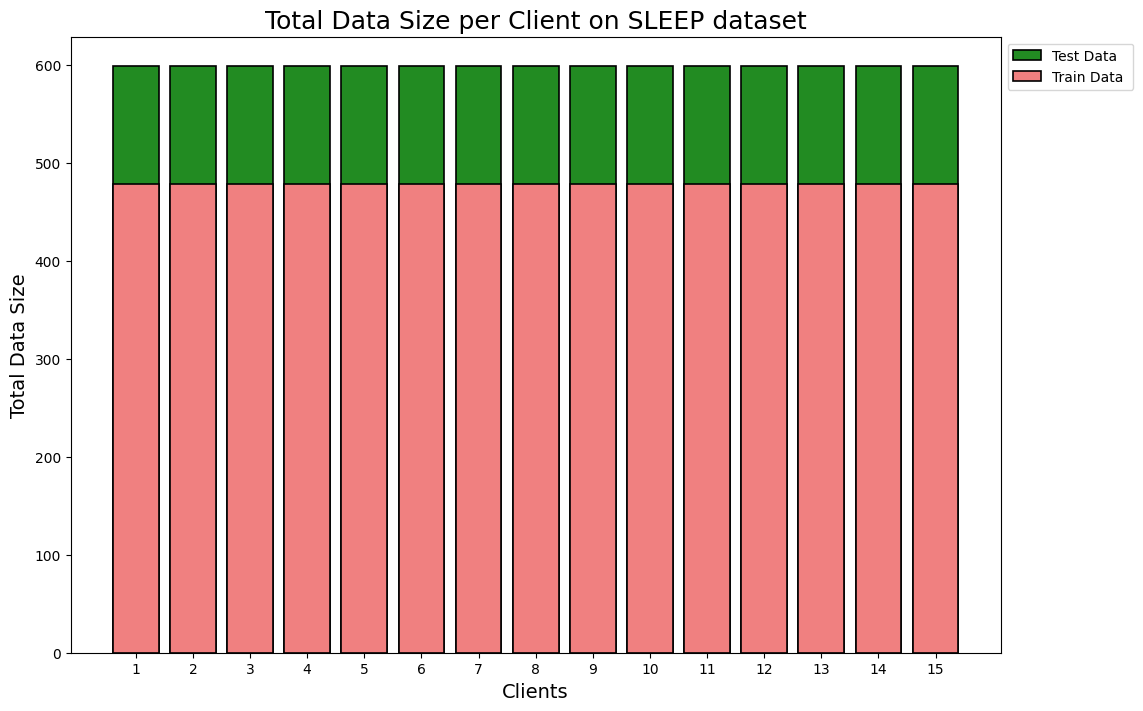

In [18]:
plt.figure(figsize=(12, 8))
plt.bar(range(1, len(total_data_sleep)+ 1), total_data_sleep, color='forestgreen', edgecolor='black', linewidth=1.2, label = 'Test Data ')
plt.bar(range(1, len(total_data_sleep)+ 1), data_sleep_train, color='lightcoral', edgecolor='black', linewidth=1.2, label = 'Train Data ')
plt.xlabel('Clients', fontsize=14)
plt.ylabel('Total Data Size', fontsize=14)
plt.title('Total Data Size per Client on SLEEP dataset', fontsize=18)
plt.xticks(range(1, len(total_data_sleep)+ 1))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

## HAR DATASET

In [19]:
json_har_file = "../dataset/HAR/config.json"
# dataset/HAR/config.json
with open(json_har_file, "r") as f:
    config_har = json.load(f)


In [20]:
config_har

{'num_clients': 30,
 'num_classes': 6,
 'Size of samples for labels in clients': [[[0, 95],
   [1, 53],
   [2, 49],
   [3, 47],
   [4, 53],
   [5, 50]],
  [[0, 59], [1, 48], [2, 47], [3, 46], [4, 54], [5, 48]],
  [[0, 58], [1, 59], [2, 49], [3, 52], [4, 61], [5, 62]],
  [[0, 60], [1, 52], [2, 45], [3, 50], [4, 56], [5, 54]],
  [[0, 56], [1, 47], [2, 47], [3, 44], [4, 56], [5, 52]],
  [[0, 57], [1, 51], [2, 48], [3, 55], [4, 57], [5, 57]],
  [[0, 57], [1, 51], [2, 47], [3, 48], [4, 53], [5, 52]],
  [[0, 48], [1, 41], [2, 38], [3, 46], [4, 54], [5, 54]],
  [[0, 52], [1, 49], [2, 42], [3, 50], [4, 45], [5, 50]],
  [[0, 53], [1, 47], [2, 38], [3, 54], [4, 44], [5, 58]],
  [[0, 59], [1, 54], [2, 46], [3, 53], [4, 47], [5, 57]],
  [[0, 50], [1, 52], [2, 46], [3, 51], [4, 61], [5, 60]],
  [[0, 57], [1, 55], [2, 47], [3, 49], [4, 57], [5, 62]],
  [[0, 59], [1, 54], [2, 45], [3, 54], [4, 60], [5, 51]],
  [[0, 54], [1, 48], [2, 42], [3, 59], [4, 53], [5, 72]],
  [[0, 51], [1, 51], [2, 47], [3, 6

In [21]:
n_har_classes = config_har['num_classes']
n_har_clients = config_har['num_clients']
har_data_info = config_har['Size of samples for labels in clients']


In [22]:
n_har_clients, n_har_classes

(30, 6)

In [23]:
har_data_info

[[[0, 95], [1, 53], [2, 49], [3, 47], [4, 53], [5, 50]],
 [[0, 59], [1, 48], [2, 47], [3, 46], [4, 54], [5, 48]],
 [[0, 58], [1, 59], [2, 49], [3, 52], [4, 61], [5, 62]],
 [[0, 60], [1, 52], [2, 45], [3, 50], [4, 56], [5, 54]],
 [[0, 56], [1, 47], [2, 47], [3, 44], [4, 56], [5, 52]],
 [[0, 57], [1, 51], [2, 48], [3, 55], [4, 57], [5, 57]],
 [[0, 57], [1, 51], [2, 47], [3, 48], [4, 53], [5, 52]],
 [[0, 48], [1, 41], [2, 38], [3, 46], [4, 54], [5, 54]],
 [[0, 52], [1, 49], [2, 42], [3, 50], [4, 45], [5, 50]],
 [[0, 53], [1, 47], [2, 38], [3, 54], [4, 44], [5, 58]],
 [[0, 59], [1, 54], [2, 46], [3, 53], [4, 47], [5, 57]],
 [[0, 50], [1, 52], [2, 46], [3, 51], [4, 61], [5, 60]],
 [[0, 57], [1, 55], [2, 47], [3, 49], [4, 57], [5, 62]],
 [[0, 59], [1, 54], [2, 45], [3, 54], [4, 60], [5, 51]],
 [[0, 54], [1, 48], [2, 42], [3, 59], [4, 53], [5, 72]],
 [[0, 51], [1, 51], [2, 47], [3, 69], [4, 78], [5, 70]],
 [[0, 61], [1, 48], [2, 46], [3, 64], [4, 78], [5, 71]],
 [[0, 56], [1, 58], [2, 55], [3

In [24]:
class_per_client = []
data_per_client = []
for client_id, data in  enumerate(har_data_info):
    print("Client : ", client_id)
    print("Class: ", [i[0] for i in data])
    print("Size: ", [i[1] for i in data])
    class_per_client.append([i[0] for i in data])
    data_per_client.append([i[1] for i in data])


Client :  0
Class:  [0, 1, 2, 3, 4, 5]
Size:  [95, 53, 49, 47, 53, 50]
Client :  1
Class:  [0, 1, 2, 3, 4, 5]
Size:  [59, 48, 47, 46, 54, 48]
Client :  2
Class:  [0, 1, 2, 3, 4, 5]
Size:  [58, 59, 49, 52, 61, 62]
Client :  3
Class:  [0, 1, 2, 3, 4, 5]
Size:  [60, 52, 45, 50, 56, 54]
Client :  4
Class:  [0, 1, 2, 3, 4, 5]
Size:  [56, 47, 47, 44, 56, 52]
Client :  5
Class:  [0, 1, 2, 3, 4, 5]
Size:  [57, 51, 48, 55, 57, 57]
Client :  6
Class:  [0, 1, 2, 3, 4, 5]
Size:  [57, 51, 47, 48, 53, 52]
Client :  7
Class:  [0, 1, 2, 3, 4, 5]
Size:  [48, 41, 38, 46, 54, 54]
Client :  8
Class:  [0, 1, 2, 3, 4, 5]
Size:  [52, 49, 42, 50, 45, 50]
Client :  9
Class:  [0, 1, 2, 3, 4, 5]
Size:  [53, 47, 38, 54, 44, 58]
Client :  10
Class:  [0, 1, 2, 3, 4, 5]
Size:  [59, 54, 46, 53, 47, 57]
Client :  11
Class:  [0, 1, 2, 3, 4, 5]
Size:  [50, 52, 46, 51, 61, 60]
Client :  12
Class:  [0, 1, 2, 3, 4, 5]
Size:  [57, 55, 47, 49, 57, 62]
Client :  13
Class:  [0, 1, 2, 3, 4, 5]
Size:  [59, 54, 45, 54, 60, 51]
Cl

In [25]:
# plot data distribution for HAR dataset and size is different for each client
num_clients = 30  # Number of clients
classes = list(range(6))  # Classes: 0 to 5
x = np.repeat(range(1, num_clients + 1), len(classes))  # Repeat client indices for each class
y = np.tile(classes, num_clients)  # Repeat class indices across all clients
sizes = data_per_client  # Sizes for each class
scaled_sizes = [np.array(s) * 5 for s in sizes]  # Adjust size multiplier for clarity



In [26]:
x

array([ 1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
        3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9,  9,  9,
        9,  9,  9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12,
       12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15,
       15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17,
       18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20,
       20, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23,
       23, 23, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 26, 26, 26,
       26, 26, 26, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 29, 29,
       29, 29, 29, 29, 30, 30, 30, 30, 30, 30])

In [27]:
np.array(sizes).flatten()

array([95, 53, 49, 47, 53, 50, 59, 48, 47, 46, 54, 48, 58, 59, 49, 52, 61,
       62, 60, 52, 45, 50, 56, 54, 56, 47, 47, 44, 56, 52, 57, 51, 48, 55,
       57, 57, 57, 51, 47, 48, 53, 52, 48, 41, 38, 46, 54, 54, 52, 49, 42,
       50, 45, 50, 53, 47, 38, 54, 44, 58, 59, 54, 46, 53, 47, 57, 50, 52,
       46, 51, 61, 60, 57, 55, 47, 49, 57, 62, 59, 54, 45, 54, 60, 51, 54,
       48, 42, 59, 53, 72, 51, 51, 47, 69, 78, 70, 61, 48, 46, 64, 78, 71,
       56, 58, 55, 57, 73, 65, 52, 40, 39, 73, 73, 83, 51, 51, 45, 66, 73,
       68, 52, 47, 45, 85, 89, 90, 46, 42, 36, 62, 63, 72, 59, 51, 54, 68,
       68, 72, 58, 59, 55, 68, 69, 72, 74, 65, 58, 65, 74, 73, 59, 55, 50,
       78, 74, 76, 57, 51, 44, 70, 80, 74, 54, 51, 46, 72, 79, 80, 53, 49,
       48, 60, 65, 69, 65, 65, 62, 62, 59, 70])

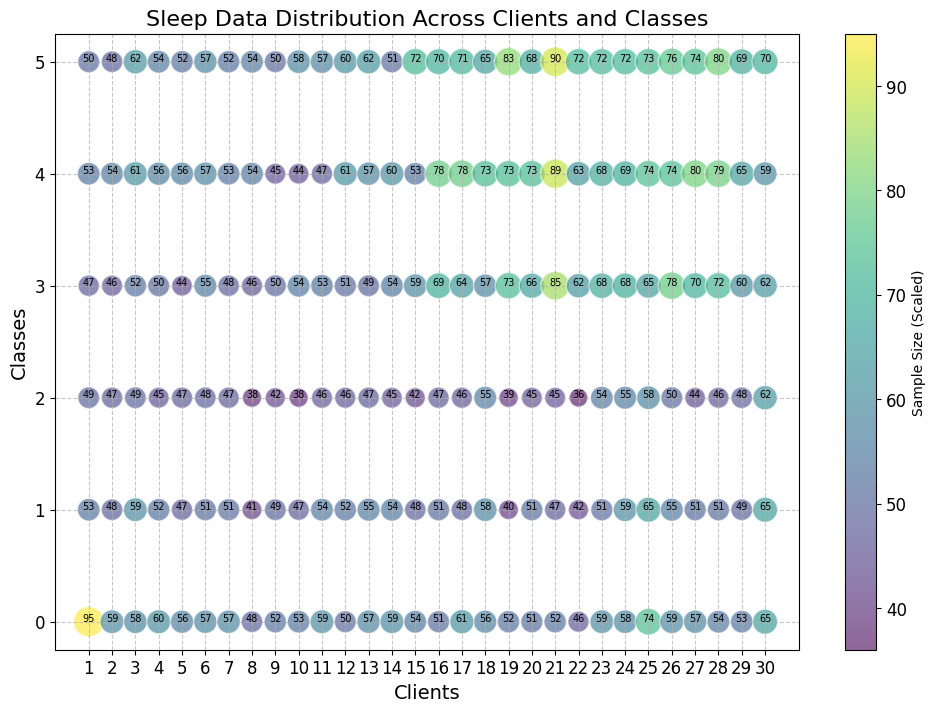

In [28]:
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(x, y, s=scaled_sizes, alpha=0.6, edgecolors="w", c=sizes, cmap='viridis')

# Set title and labels with improved font size
ax.set_title('Sleep Data Distribution Across Clients and Classes', fontsize=16)
ax.set_xlabel('Clients', fontsize=14)
ax.set_ylabel('Classes', fontsize=14)

# Set ticks with improved font size
ax.set_xticks(range(1, num_clients + 1))
ax.set_yticks(classes)
ax.tick_params(axis='both', which='major', labelsize=12)

# Add grid lines for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Add a color bar for clarity
cbar = plt.colorbar(scatter, ax=ax, label='Sample Size (Scaled)')
cbar.ax.tick_params(labelsize=12)

# Add annotations for each point
for i in range(len(x)):
    ax.annotate(f'{np.array(sizes).flatten()[i]}', (x[i], y[i]), textcoords="offset points", xytext=(0, 0), ha='center', fontsize=7, color='black')

plt.show()

In [29]:
total_data = np.array(sizes).sum(axis=1)
total_data

array([347, 302, 341, 317, 302, 325, 308, 281, 288, 294, 316, 320, 327,
       323, 328, 366, 368, 364, 360, 354, 408, 321, 372, 381, 409, 392,
       376, 382, 344, 383])

In [30]:
har_train_s = [260, 226, 255, 237, 226, 243, 231, 210, 216, 220, 237, 240, 245, 242, 246, 274, 276, 273, 270, 265, 306, 240, 279, 285, 306, 294, 282, 286, 258, 287]
har_test_s =  [87, 76, 86, 80, 76, 82, 77, 71, 72, 74, 79, 80, 82, 81, 82, 92, 92, 91, 90, 89, 102, 81, 93, 96, 103, 98, 94, 96, 86, 96]

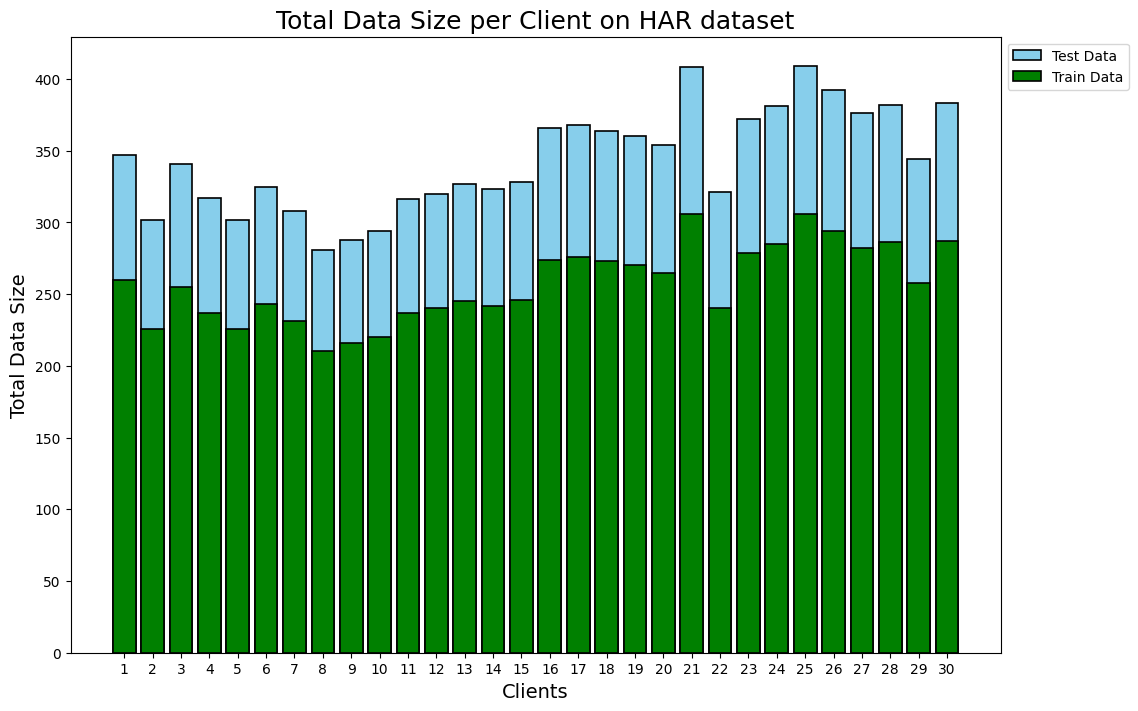

In [31]:
plt.figure(figsize=(12, 8))
plt.bar(range(1, num_clients + 1), total_data, color='skyblue', edgecolor='black', linewidth=1.2, label='Test Data')
plt.bar(range(1, num_clients + 1), har_train_s, color='green', edgecolor='black', linewidth=1.2, label='Train Data')
plt.xlabel('Clients', fontsize=14)
plt.ylabel('Total Data Size', fontsize=14)
plt.title('Total Data Size per Client on HAR dataset', fontsize=18)
plt.xticks(range(1, len(total_data)+ 1))
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

In [32]:
raw_har_file = "../dataset/HAR/train/0.npz"
with open(raw_har_file, "rb") as f: 
    raw_har = np.load(f, allow_pickle=True)['data'].tolist()

data_har = raw_har["x"]
label_har = raw_har['y']
sample_har = data_har[0].reshape(9, 128)
label_id_har = label_har[0]


In [33]:
sample_har.shape

(9, 128)

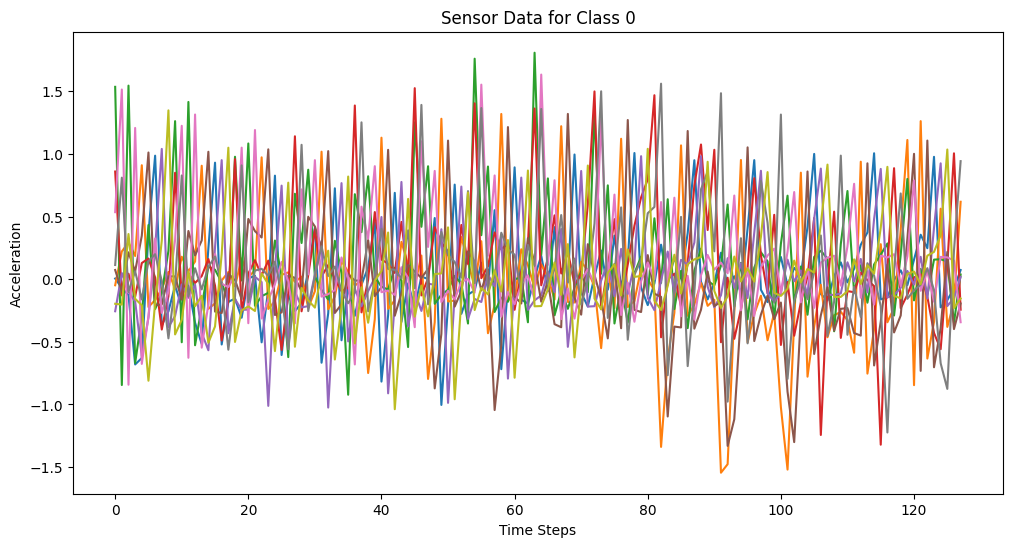

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(sample_har.T)
plt.title(f'Sensor Data for Class {label_id_har}')
plt.xlabel('Time Steps')
plt.ylabel('Acceleration')
plt.show()

In [35]:
import os 

### build model

In [36]:
import torch 
import torch.nn as nn

In [49]:
x = torch.randn(10, 9, 1, 128)
y = torch.randint(0, 6, (10,))

In [101]:
x_sl = torch.randn(10, 3, 1, 100)
y_sl = torch.randint(0, 12, (10,))

In [131]:
class HybridBN(nn.Module):
    def __init__(self, in_channels=9, dim_hidden=16*60, num_classes=6, conv_kernel_size=(1, 9), pool_kernel_size=(1, 2)):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=conv_kernel_size),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2)
        )
        self.lstm = nn.LSTM(32, 16, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(dim_hidden, 128),
            nn.ReLU(), 
            nn.Linear(128, 64),
            nn.ReLU(), 
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        out = self.conv1(x)
        out = out.mean(dim=2).permute(0, 2, 1)
        print(out.shape)
        out, _ = self.lstm(out)
        print(out.shape)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [132]:
test_file = "0.npz"
with open(test_file, "rb") as f: 
    raw_pamap2 = np.load(f, allow_pickle=True)['data'].tolist()


sample_pamap2 = raw_pamap2["x"]
label_pamap2 = raw_pamap2['y']
sample_pamap2.shape

(483, 9, 3, 256)

In [133]:
hybrid = HybridBN()
hybrid.eval()


HybridBN(
  (conv1): Sequential(
    (0): Conv2d(9, 32, kernel_size=(1, 9), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(32, 16, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=960, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=6, bias=True)
  )
)

In [135]:
out = hybrid(x)
out.shape

torch.Size([10, 60, 32])
torch.Size([10, 60, 16])


torch.Size([10, 6])

In [136]:
sl_hybrid = HybridBN(in_channels=3, dim_hidden = 16 * 49, conv_kernel_size=(1, 3) ,num_classes=12)

In [137]:
print("total Parameters: ", sum([p.numel() for p in sl_hybrid.parameters()]))


total Parameters:  113100


In [138]:
sl_hybrid(x_sl).shape

torch.Size([10, 49, 32])
torch.Size([10, 49, 16])


torch.Size([10, 12])

In [141]:
pamap2_data  = torch.randn(10, 9, 3, 256)
pamap2_label = torch.randint(0, 12, (10,))
pamap2_hybrid = HybridBN(in_channels=9, dim_hidden=16*124, num_classes=12, conv_kernel_size=(1, 9), pool_kernel_size=(1, 2))

In [142]:
out = pamap2_hybrid(pamap2_data)

torch.Size([10, 124, 32])
torch.Size([10, 124, 16])


In [143]:
print("total Parameters: ", sum([p.numel() for p in pamap2_hybrid.parameters()]))


total Parameters:  269004


### plot run on hybrid model

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

In [9]:
with open('../results/PAMAP2_FedDistill_test_0_0.95_32_300_9_2025_01_23_17_11.pkl','rb') as f:
  feddist = pickle.load(f)
with open('../results/PAMAP2_FedFomo_test_0_0.95_32_300_9_2025_01_23_16_04.pkl','rb') as f:
  fedfomo = pickle.load(f)

with open('../results/PAMAP2_FedMTL_test_0_0.95_32_300_9_2025_01_23_17_38.pkl','rb') as f:
  fedMTL = pickle.load(f)

with open('../results/PAMAP2_MOON_test_0_0.95_32_300_9_2025_01_23_16_38.pkl','rb') as f:
  fedmoon = pickle.load(f)

with open('../results/PAMAP2_FedProx_test_0_0.95_32_300_9_2025_01_23_18_05.pkl','rb') as f:
   fedprox= pickle.load(f)

# with open('/content/SLEEP_FedKDX_test_0_0.9_64_500_15_2024_10_22_03_34.pkl','rb') as f:
#   fedkdxbn = pickle.load(f)

# with open('/content/SLEEP_FedKD_test_0_0.9_64_500_15_2024_10_22_02_37.pkl','rb') as f:
#   fedkd = pickle.load(f)

In [13]:
# print len 
print(len(feddist['rs_test_acc']))
print(len(fedfomo['rs_test_acc']))
print(len(fedMTL['rs_test_acc']))
print(len(fedmoon['rs_test_acc']))

301
301
301
301


In [14]:
accs = []
aucs = []
losses = []
f1_scores = []
recall = []
for i in range(len(feddist['rs_test_acc'])):
  acc_feddist = feddist['rs_test_acc'][i]
  acc_fedfomo = fedfomo['rs_test_acc'][i]
  acc_fedMTL = fedMTL['rs_test_acc'][i]
  acc_fedmoon = fedmoon['rs_test_acc'][i]
  acc_fedprox = fedprox['rs_test_acc'][i]
#   acc_kdx = fedkdx['rs_test_acc'][i]
  # acc_gen = fedgen['rs_test_acc'][i]
  # acc_avg = fedavg['rs_test_acc'][i]
#   acc_kdxbn = fedkdxbn['rs_test_acc'][i]
#   acc_kd = fedkd['rs_test_acc'][i]
  # accs.append([acc_feddist, acc_fedfomo, ])
  # accs.append(acc_kdx)
#   accs.append([acc_feddist,acc_fedfomo, acc_fedMTL, acc_fedmoon,  acc_kdx,acc_kdxbn, acc_kd])
  accs.append([acc_feddist,acc_fedfomo, acc_fedMTL, acc_fedmoon, acc_fedprox]) 
  loss_feddist = feddist['rs_train_loss'][i]
  loss_fedfomo = fedfomo['rs_train_loss'][i]
  loss_fedMTL = fedMTL['rs_train_loss'][i]
  loss_fedmoon = fedmoon['rs_train_loss'][i]
  loss_fedprox = fedprox['rs_train_loss'][i]
#   loss_kdx = fedkdx['rs_train_loss'][i]
  # loss_gen = fedgen['rs_train_loss'][i]
  # loss_avg = fedavg['rs_train_loss'][i]
#   loss_kdxbn = fedkdxbn['rs_train_loss'][i]
  # losses.append(loss_kdx)
#   loss_kd = fedkd['rs_train_loss'][i]
#   losses.append([loss_feddist,loss_fedfomo,  loss_fedMTL, loss_fedmoon, loss_kdx,loss_kdxbn, loss_kd])
  losses.append([loss_feddist,loss_fedfomo,  loss_fedMTL, loss_fedmoon, loss_fedprox])

  auc_feddist = feddist['rs_test_auc'][i]
  auc_fedfomo = fedfomo['rs_test_auc'][i]
  # auc_fedprox = fedprox['rs_test_auc'][i]
  auc_fedMTL = fedMTL['rs_test_auc'][i]
  auc_fedmoon = fedmoon['rs_test_auc'][i]
  auc_fedprox = fedprox['rs_test_auc'][i]
#   auc_kdx = fedkdx['rs_test_auc'][i]
#   auc_kdxbn = fedkdxbn['rs_test_auc'][i]
#   auc_kd = fedkd['rs_test_auc'][i]
  # auc_kdx = fedkdx['rs_test_auc'][i]
  # auc_gen = fedgen['rs_test_auc'][i]
  # auc_avg = fedavg['rs_test_auc'][i]
  # auc_kd = fedkd['rs_test_auc'][i]
#   aucs.append([auc_feddist, auc_fedfomo, auc_fedMTL, auc_fedmoon, auc_kdx, auc_kdxbn, auc_kd])
  aucs.append([auc_feddist, auc_fedfomo, auc_fedMTL, auc_fedmoon, auc_fedprox])

  f1_feddist = feddist['rs_test_f1'][i]
  f1_fedfomo = fedfomo['rs_test_f1'][i]
  f1_fedMTL = fedMTL['rs_test_f1'][i]
  f1_fedmoon = fedmoon['rs_test_f1'][i]
  f1_fedprox = fedprox['rs_test_f1'][i]
#   f1_kdx = fedkdx['rs_test_f1'][i]
#   f1_kdxbn = fedkdxbn['rs_test_f1'][i]
#   f1_kd = fedkd['rs_test_f1'][i]
#   f1_scores.append([f1_feddist, f1_fedfomo, f1_fedMTL, f1_fedmoon, f1_kdx, f1_kdxbn, f1_kd])
  f1_scores.append([f1_feddist, f1_fedfomo, f1_fedMTL, f1_fedmoon, f1_fedprox])

  rc_feddist = feddist['rs_test_rc'][i]
  rc_fedfomo = fedfomo['rs_test_rc'][i]
  rc_fedMTL = fedMTL['rs_test_rc'][i]
  rc_fedmoon = fedmoon['rs_test_rc'][i]
  rc_fedprox = fedprox['rs_test_rc'][i]
#   rc_kdx = fedkdx['rs_test_rc'][i]
#   rc_kdxbn = fedkdxbn['rs_test_rc'][i]
#   rc_kd = fedkd['rs_test_rc'][i]
#   recall.append([rc_feddist, rc_fedfomo, rc_fedMTL, rc_fedmoon, rc_kdx, rc_kdxbn, rc_kd])
  recall.append([rc_feddist, rc_fedfomo, rc_fedMTL, rc_fedmoon, rc_fedprox])


  # aucs.append([auc_fedamp, auc_fedavg, auc_fedfomo, auc_fedprox])



In [16]:
len(accs), len(losses), len(aucs), len(f1_scores), len(recall)

(301, 301, 301, 301, 301)

In [18]:
max(accs)

[0.9608417687799681,
 0.9347362812999467,
 0.958444326052211,
 0.8297815663292488,
 0.8431006925945658]

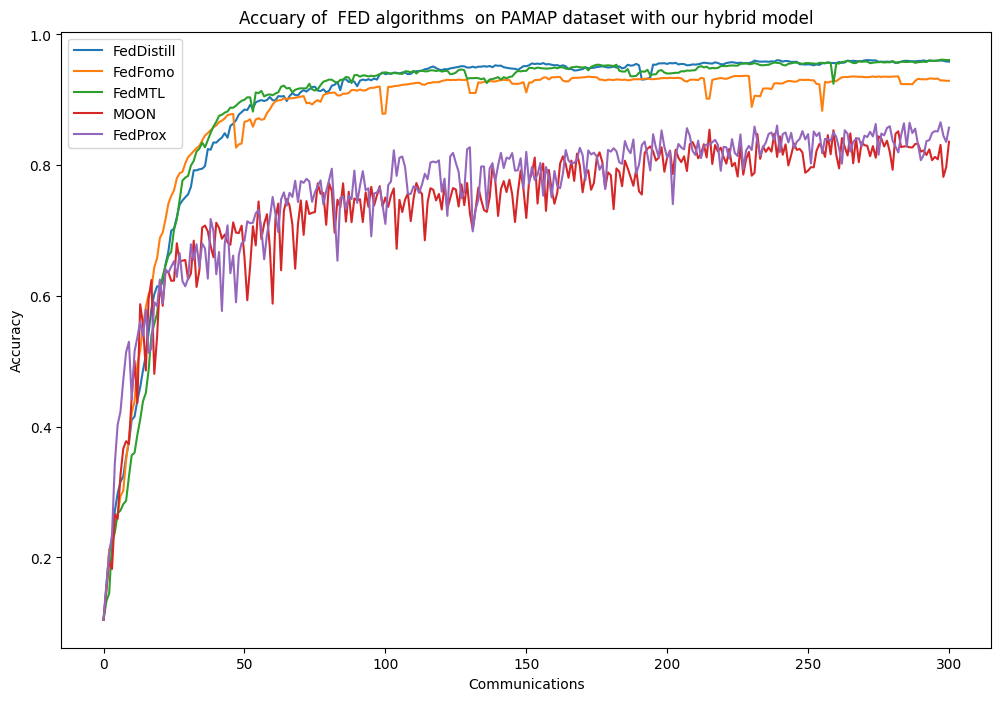

In [25]:
plt.figure(figsize = (12,8))
plt.plot(np.array(accs))
plt.title("Accuary of  FED algorithms  on PAMAP dataset with our hybrid model")
plt.xlabel("Communications")
plt.ylabel("Accuracy")
plt.legend(["FedDistill","FedFomo" ,"FedMTL", "MOON",  "FedProx",])
# plt.legend(legends)
plt.savefig("acc.png")
plt.show()

In [ ]:
#load csv dat